- LCC
- Image Preprocessing
    - Breast Cropping
    - 224 x 224 pixels
    - Data Augmentation (Random Horizontal Flip)
- Balanced datasets with around 6000 of each classes

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-02-23 20:52:38.159652: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-23 20:52:38.616570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2025-02-23 20:52:39.376622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-23 20:52:39.381080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-23 20:52:39.403028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from collections import Counter
import numpy as np
import cv2

In [3]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/D1-D6_matched.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [4]:
# Define the correct base path
correct_base_path = "/mnt/data2"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
# print(data['FilePath'].head())

# Filter out rows with invalid or missing FilePath
data = data.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data = data[data['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

In [5]:
# Map ethnicity to 3 classes
def map_ethnicity(ethnicity):
    mapping = {
        "BR": "White", "EE": "White", "FR": "White", "NE": "White", "SE": "White", "WE": "White",
        "EA": "Asian - East and Southeast",
        "SA": "Asian - South"
    }
    return mapping.get(ethnicity, "Other")

data['ethnicity'] = data['ethnicity'].apply(map_ethnicity)

# Filter for selected ethnicities
data = data[data['ethnicity'].isin(["White", "Asian - East and Southeast", "Asian - South"])]

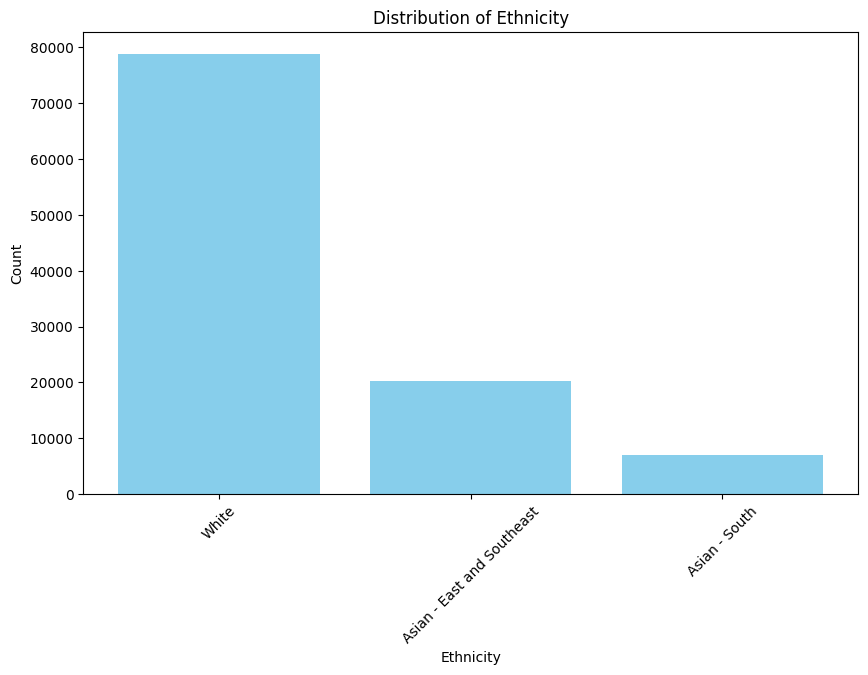

In [7]:
# Count ethnicity distribution
ethnicity_counts = data['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
# plt.style.use('default')
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Stratified sampling: Select 6000 images per ethnicity
target_per_class = 6000
stratified_samples = []

# For each ethnicity, sample up to 6000
for ethnicity, group in data.groupby('ethnicity'):
    stratified_samples.append(group.sample(
        n=min(target_per_class, len(group)),  # Use all if less than target_per_class
        random_state=42
    ))

# Combine the samples into one DataFrame
data_sample = pd.concat(stratified_samples, ignore_index=True)

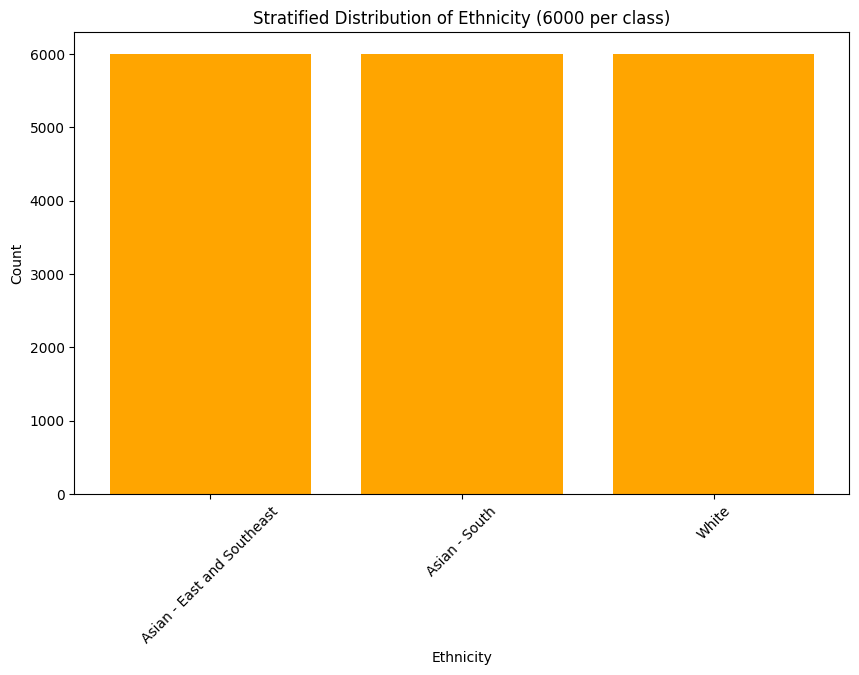

In [9]:
# Show the new distribution of ethnicity
ethnicity_counts = data_sample['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Stratified Distribution of Ethnicity (6000 per class)')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Preprocess Function (Binary Mask Extraction)
def preprocess(pngPath, output_dir):
    """Generate binary mask of largest contour (breast tissue) from the image."""
    img = cv2.imread(pngPath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {pngPath}")
    
    # Threshold to create binary mask (breast tissue)
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)
    
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros(img.shape, np.uint8)
    cv2.fillPoly(mask, [largest_contour], 1)  # Mask with white areas (value=1)
    
    # Crop the mask to the bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    maskCropped = mask[y:y+h, x:x+w]
    
    # Create output directory for patient
    patient_dir = os.path.dirname(pngPath).replace("/", "_").replace("\\", "_")
    patient_output_dir = os.path.join(output_dir, patient_dir)
    os.makedirs(patient_output_dir, exist_ok=True)
    
    # Save the mask
    output_mask_path = os.path.join(
        patient_output_dir,
        os.path.basename(pngPath).replace(".png", "_mask.png")
    )
    cv2.imwrite(output_mask_path, (maskCropped * 255).astype(np.uint8))
    
    return output_mask_path, maskCropped

In [11]:
# Encode Labels
def encode_labels(labels):
    """Convert string labels to numeric labels."""
    label_mapping = {label: idx for idx, label in enumerate(sorted(set(labels)))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

# Resize with Padding (Fix Distortion)
def resize_with_padding(image, target_height, target_width):
    """Resize image with padding to maintain aspect ratio."""
    image_shape = tf.shape(image)[:2]  # (height, width)
    
    scale = tf.minimum(
        target_width / tf.cast(image_shape[1], tf.float32),
        target_height / tf.cast(image_shape[0], tf.float32)
    )
    
    new_height = tf.cast(tf.round(tf.cast(image_shape[0], tf.float32) * scale), tf.int32)
    new_width = tf.cast(tf.round(tf.cast(image_shape[1], tf.float32) * scale), tf.int32)
    
    # Resize image while preserving aspect ratio
    image = tf.image.resize(image, [new_height, new_width])
    
    # Calculate padding
    pad_height = target_height - new_height
    pad_width = target_width - new_width
    
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    
    # Add padding with zero values
    image = tf.pad(
        image,
        [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]],
        constant_values=0
    )
    return image

### Count White Pixels

In [23]:
import seaborn as sns

white_pixel_counts = []
ethnicities = []

# Data Preprocessing Pipeline
output_dir = "/tmp/e3/segmentation_processed_images"
lcc_only_filepaths, lcc_only_labels = [], []

# Assume data_sample is already defined (with 'FilePath' and 'patient_id' columns)
for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]  # Only process LCC view

        if lcc_files:
            try:
                mask_path, mask = preprocess(lcc_files[0], output_dir)
                lcc_only_filepaths.append(mask_path)

                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue

                label = matching_rows['ethnicity'].iloc[0]
                lcc_only_labels.append(label)

                # Count white pixels (breast tissue area)
                white_pixel_count = cv2.countNonZero(mask)
                white_pixel_counts.append(white_pixel_count)
                ethnicities.append(label)

            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

def encode_labels(labels):
    """Convert string labels to numeric labels."""
    label_mapping = {label: idx for idx, label in enumerate(sorted(set(labels)))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_train_lcc_labels, lcc_label_mapping = encode_labels(lcc_only_labels)

df = pd.DataFrame({
    'WhitePixelCount': white_pixel_counts,
    'Ethnicity': ethnicities
})

'''
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='WhitePixelCount', hue='Ethnicity', bins=30, kde=True)
plt.title('Distribution of White Pixel Counts by Ethnicity')
plt.xlabel('White Pixel Count (Breast Tissue Size)')
plt.ylabel('Frequency')
plt.show()
'''

"\nplt.figure(figsize=(10, 6))\nsns.histplot(data=df, x='WhitePixelCount', hue='Ethnicity', bins=30, kde=True)\nplt.title('Distribution of White Pixel Counts by Ethnicity')\nplt.xlabel('White Pixel Count (Breast Tissue Size)')\nplt.ylabel('Frequency')\nplt.show()\n"

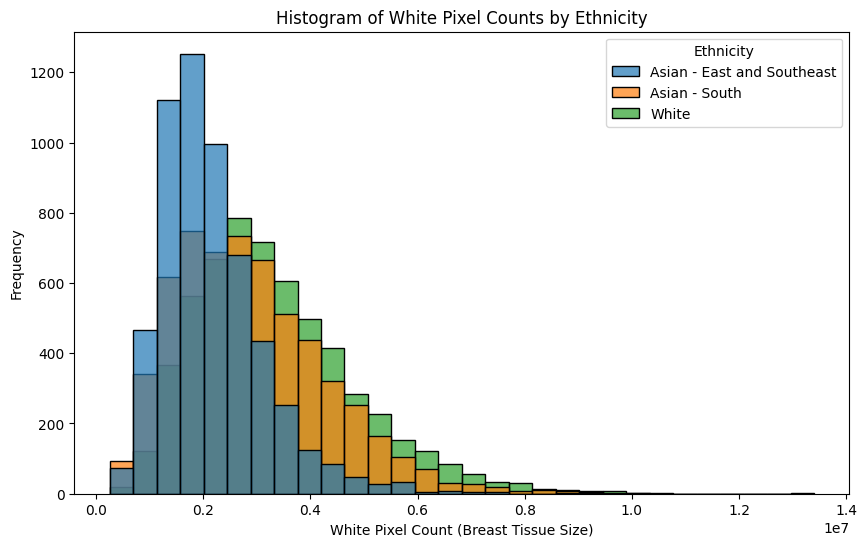

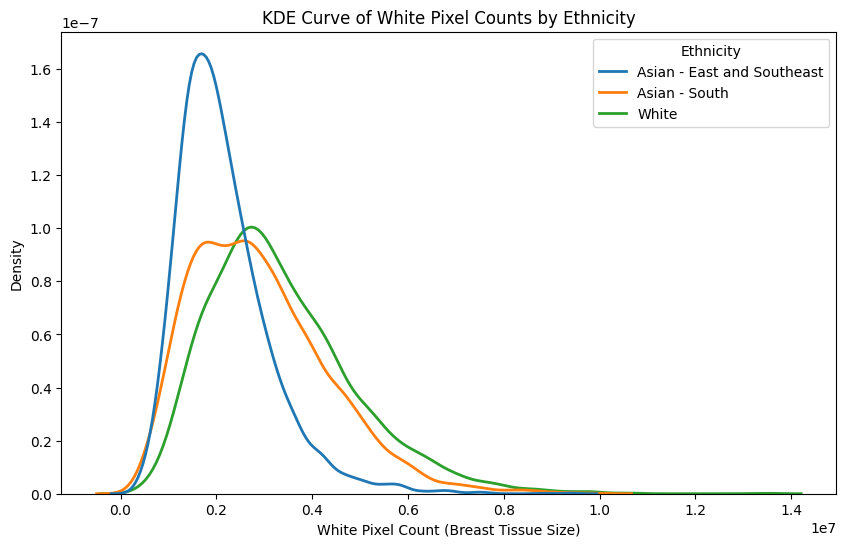

In [26]:
# Histogram Only (No KDE Curve)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='WhitePixelCount', hue='Ethnicity', bins=30, kde=False, edgecolor='black', alpha=0.7)
plt.title('Histogram of White Pixel Counts by Ethnicity')
plt.xlabel('White Pixel Count (Breast Tissue Size)')
plt.ylabel('Frequency')
plt.show()

#  KDE Curve Only
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='WhitePixelCount', hue='Ethnicity', fill=False, linewidth=2)
plt.title('KDE Curve of White Pixel Counts by Ethnicity')
plt.xlabel('White Pixel Count (Breast Tissue Size)')
plt.ylabel('Density')
plt.show()

Descriptive Statistics by Ethnicity:
                             count          mean     median           std  \
Ethnicity                                                                  
Asian - East and Southeast   5618  2.157100e+06  1969139.5  9.745598e+05   
Asian - South                5860  2.899942e+06  2700222.0  1.426265e+06   
White                        5792  3.357841e+06  3101235.0  1.520313e+06   

                               min       max  
Ethnicity                                     
Asian - East and Southeast  324201   9423265  
Asian - South               255576   9909408  
White                       373565  13401017  

One-Way ANOVA Result:
F-statistic = 1178.0160, p-value = 0.0000e+00
Significant differences exist between at least two ethnicities.

Tukey HSD Post-hoc Test Results:
                    Multiple Comparison of Means - Tukey HSD, FWER=0.05                   
          group1               group2      meandiff  p-adj    lower       upper    rejec

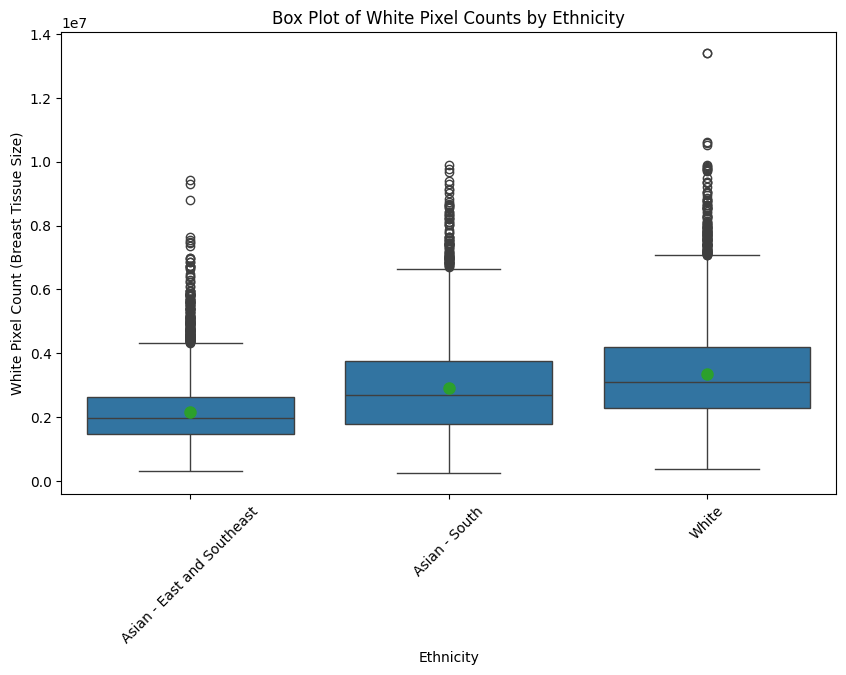

In [13]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Descriptive Statistics
desc_stats = df.groupby('Ethnicity')['WhitePixelCount'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
print("Descriptive Statistics by Ethnicity:\n", desc_stats)

# One-Way ANOVA Test
# Extract pixel counts for each ethnicity group
groups = [df[df['Ethnicity'] == ethnicity]['WhitePixelCount'] for ethnicity in df['Ethnicity'].unique()]

anova_result = stats.f_oneway(*groups)
print(f"\nOne-Way ANOVA Result:\nF-statistic = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4e}")

if anova_result.pvalue < 0.05:
    print("Significant differences exist between at least two ethnicities.")
else:
    print("No significant differences found between the ethnicities.")

# Post-hoc Tukey HSD Test (if ANOVA is significant)
if anova_result.pvalue < 0.05:
    tukey_result = pairwise_tukeyhsd(endog=df['WhitePixelCount'], groups=df['Ethnicity'], alpha=0.05)
    print("\nTukey HSD Post-hoc Test Results:\n", tukey_result.summary())

# Visualization: Box Plot of White Pixel Counts by Ethnicity
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Ethnicity', y='WhitePixelCount', showmeans=True, meanprops={"marker": "o", "markersize": 8, "color": "red"})
plt.title('Box Plot of White Pixel Counts by Ethnicity')
plt.ylabel('White Pixel Count (Breast Tissue Size)')
plt.xlabel('Ethnicity')
plt.xticks(rotation=45)
plt.show()

### Cont. Binary Masks

In [14]:
# Create TensorFlow Dataset (Binary Masks Only)
def create_mask_dataset(filepaths, labels, augment=False):
    """Create a TensorFlow dataset using binary masks only."""
    def load_mask(filepath, label):
        mask = tf.image.decode_png(tf.io.read_file(filepath), channels=1)
        mask = resize_with_padding(mask, 512, 512)  # Resize with padding (fixed distortion)
        mask = tf.cast(mask, tf.float32) / 255.0   # Normalize to [0, 1]
        
        # Data Augmentation (if enabled)
        if augment:
            mask = tf.image.random_flip_left_right(mask)
        return mask, label
    
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(load_mask, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Data Preprocessing Pipeline
output_dir = "/tmp/e3/segmentation_processed_images"
lcc_only_filepaths, lcc_only_labels = [], []

# Assume data_sample is already defined (with 'FilePath' and 'patient_id' columns)
for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]  # Only process LCC view
        
        if lcc_files:
            try:
                mask_path, mask = preprocess(lcc_files[0], output_dir)
                lcc_only_filepaths.append(mask_path)
                
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                
                label = matching_rows['ethnicity'].iloc[0]
                lcc_only_labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

In [15]:
train_lcc_filepaths, test_lcc_filepaths, train_lcc_labels, test_lcc_labels = train_test_split(
    lcc_only_filepaths, lcc_only_labels, 
    test_size=0.25, 
    stratify=lcc_only_labels, 
    random_state=42
)

encoded_train_lcc_labels, lcc_label_mapping = encode_labels(train_lcc_labels)
encoded_test_lcc_labels = [lcc_label_mapping[label] for label in test_lcc_labels]

# 8. Create Datasets (Training and Testing)
train_lcc_dataset = create_mask_dataset(
    train_lcc_filepaths, 
    encoded_train_lcc_labels, 
    augment=True
).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)

test_lcc_dataset = create_mask_dataset(
    test_lcc_filepaths, 
    encoded_test_lcc_labels, 
    augment=False
).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)

2025-02-23 21:24:50.659445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-23 21:24:50.660611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-23 21:24:50.661742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

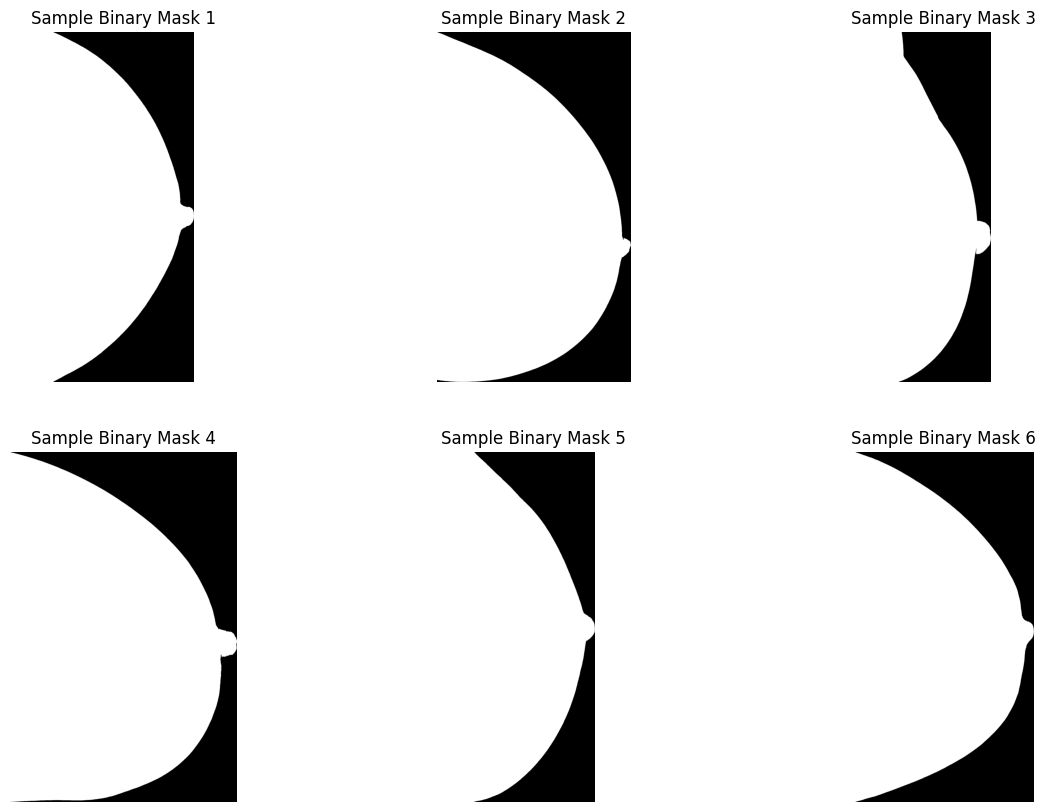

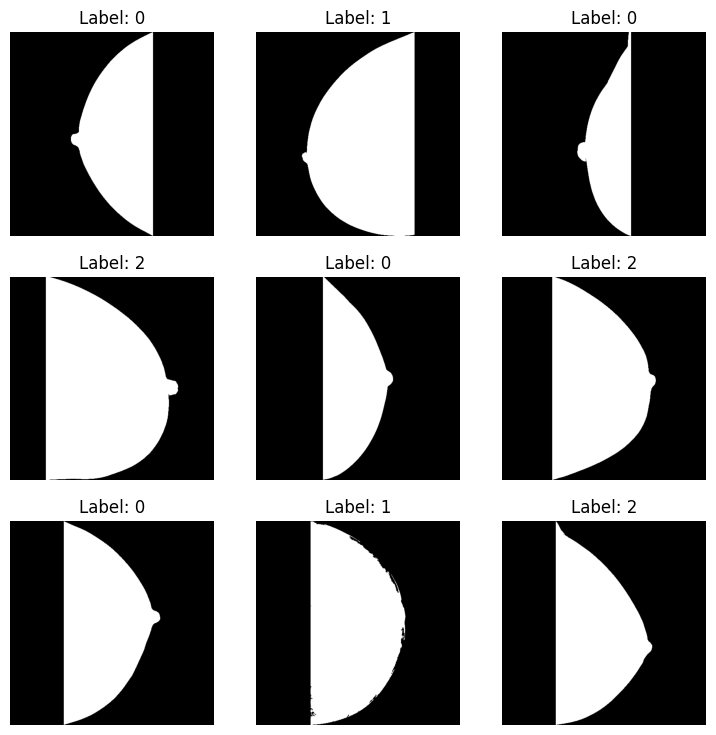

In [16]:
# Visualize Sample Masks (Check Preprocessing)
plt.figure(figsize=(15, 10))
for i, mask_path in enumerate(train_lcc_filepaths[:6]):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 3, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Sample Binary Mask {i+1}")
    plt.axis('off')
plt.show()

# Visualize Batch from Training Dataset
def show_images_from_dataset(dataset, num_images=9):
    """Display sample masks from a dataset."""
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
        
        plt.figure(figsize=(9, 9))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")
        plt.show()
        break

# Show images from the training dataset
show_images_from_dataset(train_lcc_dataset)


### Save the Processed Images and Labels

In [30]:
# Save train dataset metadata
train_metadata = pd.DataFrame({'filepath': train_lcc_filepaths, 'label': train_lcc_labels})
train_metadata.to_csv("/tmp/e3/train_metadata_1024.csv", index=False)

# Save test dataset metadata
test_metadata = pd.DataFrame({'filepath': test_lcc_filepaths, 'label': test_lcc_labels})
test_metadata.to_csv("/tmp/e3/test_metadata_1024.csv", index=False)

# Save label mapping
import json

with open("/tmp/e3/label_mapping_1024.json", "w") as f:
    json.dump(lcc_label_mapping, f)


### Load Images and Labels for Future Use

In [31]:
# Load the CSV files
train_metadata = pd.read_csv("/tmp/e3/train_metadata_224.csv")
test_metadata = pd.read_csv("/tmp/e3/test_metadata_224.csv")

# Load the label mapping
with open("/tmp/e3/label_mapping_224.json", "r") as f:
    lcc_label_mapping = json.load(f)

# Convert labels to numeric format
encoded_train_lcc_labels = [lcc_label_mapping[label] for label in train_metadata['label']]
encoded_test_lcc_labels = [lcc_label_mapping[label] for label in test_metadata['label']]

train_lcc_filepaths = train_metadata['filepath'].tolist()
test_lcc_filepaths = test_metadata['filepath'].tolist()

In [32]:
train_lcc_dataset = create_lcc_dataset(
    train_lcc_filepaths, encoded_train_lcc_labels, augment=True
).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)

test_lcc_dataset = create_lcc_dataset(
    test_lcc_filepaths, encoded_test_lcc_labels, augment=False
).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)

### EfficientNetB3

In [17]:
tf.keras.backend.clear_session()

In [17]:
# Define input layer for 1-channel (grayscale) input
input_layer_lcc = Input(shape=(512, 512, 1))

# Convert 1-channel grayscale image to 3-channel input using a 1x1 Conv layer
x = Conv2D(3, (1, 1), activation='linear')(input_layer_lcc)

# Load EfficientNetB3 without passing input_tensor, setting input_shape instead
base_model_lcc = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Apply the grayscale conversion before passing data to EfficientNetB3
x = base_model_lcc(x)

# Freeze base model layers initially
base_model_lcc.trainable = False  

# Add custom layers on top of EfficientNetB3
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_lcc = Dense(len(lcc_label_mapping), activation='softmax')(x)

# Define the final model
model_lcc = Model(inputs=input_layer_lcc, outputs=output_lcc)

# Compile the model
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Start with a smaller learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_lcc = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)

# Fine-tuning (Unfreeze base model for additional training)
base_model_lcc.trainable = True
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again with fine-tuning
history_finetune = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=20,  # Fewer epochs for fine-tuning
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7)
    ]
)

Epoch 1/50


2025-02-23 21:24:58.974820: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-02-23 21:24:59.639809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-23 21:24:59.658067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-02-23 21:24:59.933614: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa93c0228b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-23 21:24:59.933638: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5500, Compute Capability 8.6
2025-02-23 21:24:59.933645: I tensorflow/compiler/xla/service/service.cc:176]

810/810 [==============================] - 257s 310ms/step - loss: 1.1034 - accuracy: 0.3331 - val_loss: 1.0988 - val_accuracy: 0.3256 - lr: 1.0000e-04
Epoch 2/50
810/810 [==============================] - 251s 309ms/step - loss: 1.1000 - accuracy: 0.3379 - val_loss: 1.0984 - val_accuracy: 0.3393 - lr: 1.0000e-04
Epoch 3/50
810/810 [==============================] - 251s 310ms/step - loss: 1.0998 - accuracy: 0.3339 - val_loss: 1.0982 - val_accuracy: 0.3340 - lr: 1.0000e-04
Epoch 4/50
810/810 [==============================] - 251s 309ms/step - loss: 1.0987 - accuracy: 0.3440 - val_loss: 1.1010 - val_accuracy: 0.3353 - lr: 1.0000e-04
Epoch 5/50
810/810 [==============================] - 251s 309ms/step - loss: 1.0916 - accuracy: 0.3629 - val_loss: 1.0866 - val_accuracy: 0.4523 - lr: 1.0000e-04
Epoch 6/50
810/810 [==============================] - 251s 310ms/step - loss: 1.0443 - accuracy: 0.4310 - val_loss: 1.0059 - val_accuracy: 0.4924 - lr: 1.0000e-04
Epoch 7/50
810/810 [=============

2025-02-24 00:54:12.150863: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


810/810 [==============================] - 398s 453ms/step - loss: 0.9591 - accuracy: 0.5133 - val_loss: 1.0822 - val_accuracy: 0.3893 - lr: 1.0000e-05
Epoch 2/20
810/810 [==============================] - 366s 452ms/step - loss: 0.9116 - accuracy: 0.5520 - val_loss: 0.9169 - val_accuracy: 0.5491 - lr: 1.0000e-05
Epoch 3/20
810/810 [==============================] - 364s 450ms/step - loss: 0.8977 - accuracy: 0.5628 - val_loss: 0.9910 - val_accuracy: 0.4847 - lr: 1.0000e-05
Epoch 4/20
810/810 [==============================] - 366s 452ms/step - loss: 0.8790 - accuracy: 0.5789 - val_loss: 1.0419 - val_accuracy: 0.4910 - lr: 5.0000e-06
Epoch 5/20
810/810 [==============================] - 366s 452ms/step - loss: 0.8701 - accuracy: 0.5861 - val_loss: 0.9329 - val_accuracy: 0.5509 - lr: 2.5000e-06


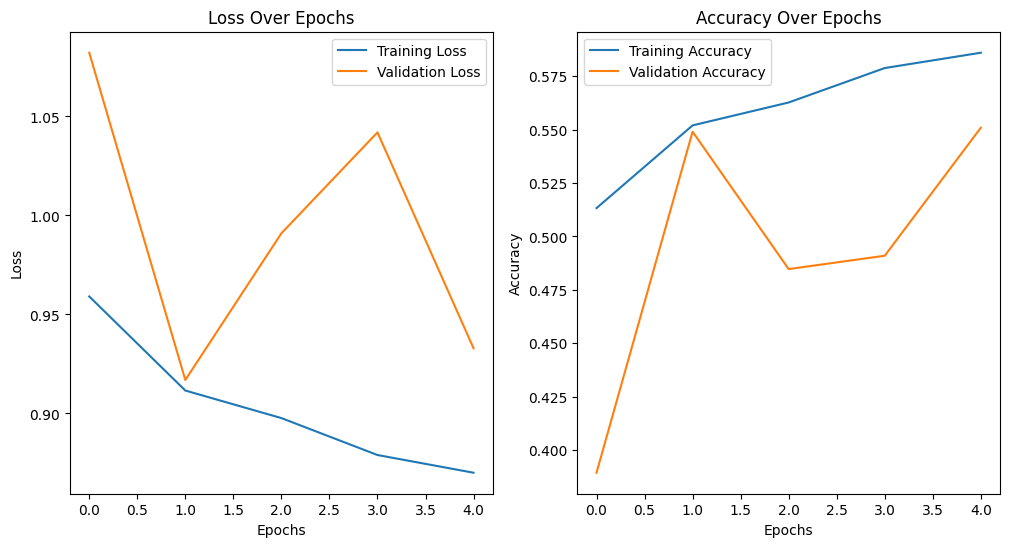

In [18]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

270/270 [==============================] - 25s 87ms/step


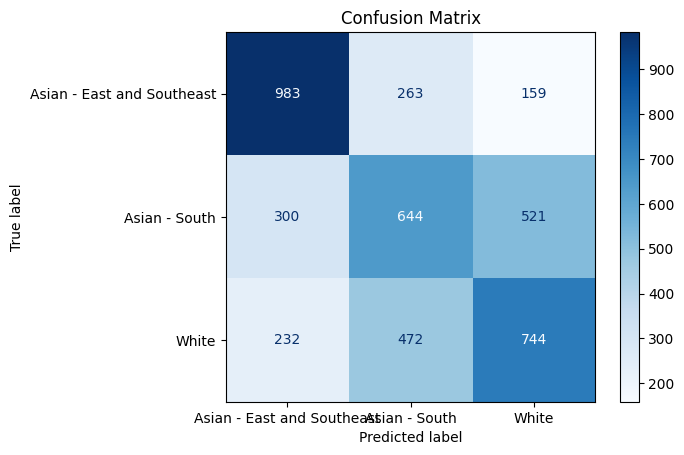

Classification Report:
                            precision    recall  f1-score   support

Asian - East and Southeast       0.65      0.70      0.67      1405
             Asian - South       0.47      0.44      0.45      1465
                     White       0.52      0.51      0.52      1448

                  accuracy                           0.55      4318
                 macro avg       0.55      0.55      0.55      4318
              weighted avg       0.54      0.55      0.55      4318



In [19]:
# Evaluate the model and compute metrics
predictions = model_lcc.predict(test_lcc_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_lcc_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(lcc_label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(lcc_label_mapping.keys()),
    zero_division=1  # Sets undefined metrics to 1 instead of raising warnings
))

In [20]:
# Convert confusion matrix to binary format per class
sensitivity = {}
specificity = {}

for i, class_name in enumerate(lcc_label_mapping.keys()):
    # One-vs-all approach
    TP = conf_matrix[i, i]  # True Positives
    FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives
    FP = np.sum(conf_matrix[:, i]) - TP  # False Positives
    TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

    # Compute sensitivity & specificity
    sensitivity[class_name] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[class_name] = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print results
print("Sensitivity (Recall) per class:")
for class_name, value in sensitivity.items():
    print(f"{class_name}: {value:.4f}")

print("\nSpecificity per class:")
for class_name, value in specificity.items():
    print(f"{class_name}: {value:.4f}")

Sensitivity (Recall) per class:
Asian - East and Southeast: 0.6996
Asian - South: 0.4396
White: 0.5138

Specificity per class:
Asian - East and Southeast: 0.8174
Asian - South: 0.7424
White: 0.7631


In [ ]:
# Save the model
model_lcc.save('Mammo_EfficientNetB3_3class_1024_model.h5')

/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
